# Fraud Detection Exercise

## Table of Content
1. Introduction
2. Data exploration
3. Answers to Question 1
4. Feature engineering
5. Feature selection
6. Modelling
7. Results

## 1. Introduction
This project is a prediction of fraud and non-fraud transactions. This makes the project a binary classification problem. As we identify in this section, the dataset is heavily imbalanced with the fraudulant transactions are only occuring less than 1 in 100. Therefore I will need to employ techniques to counter that. I also combine the two train and test datasets and create features. 

In [58]:
# import the required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geoplot.crs as gcrs
from plotly.subplots import make_subplots
import plotly.express as px
import geopandas as gpd
import seaborn as sns
import geoplot as gplt
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.linear_model import LogisticRegression
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import confusion_matrix,classification_report
import lightgbm as lgb
from tabulate import tabulate
import optuna
from sklearn.metrics import roc_curve
from matplotlib import pyplot
import us
from shapely.geometry import Point
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter
from shapely.geometry import Polygon
import holidays
from datetime import datetime
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline


In [2]:
test = pd.read_csv('tr_fincrime_test.csv').reset_index()

In [3]:
train = pd.read_csv('tr_fincrime_train.csv').reset_index()

In [18]:

train['dataset'] = 'train'
test['dataset'] = 'test'

df = pd.concat([train, test])

In [3]:
train.head()

,index,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [87]:
train.shape

(1296675, 27)

In [93]:
train['is_fraud'].value_counts()

is_fraud
0    1289169
1       7506
Name: count, dtype: int64

In [94]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 27 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   index                  1296675 non-null  int64         
 1   Unnamed: 0             1296675 non-null  int64         
 2   trans_date_trans_time  1296675 non-null  datetime64[ns]
 3   cc_num                 1296675 non-null  int64         
 4   merchant               1296675 non-null  object        
 5   category               1296675 non-null  object        
 6   amt                    1296675 non-null  float64       
 7   first                  1296675 non-null  object        
 8   last                   1296675 non-null  object        
 9   gender                 1296675 non-null  object        
 10  street                 1296675 non-null  object        
 11  city                   1296675 non-null  object        
 12  state                  12966

## 2. Question No. 1 : Analyze Customer Transactions

There are a number of insights that can be generated with the data that we have on the fraud incidence. The first insight is on the geographic location where the fraud is occuring. 

### 2.1. Geographies of fraud occurence
First and the second visualization show the fraud occurence in different states as a percentage of total frauds. This shows where the frauds are occurring and where the fraud prevention effort should go to. As the two visualizations suggest, most frauds are hapenning in New York, Texas and Pnnsylvania states. It becomes clearer in the  bar chart too. 

In [25]:
# freature engineering prior to visualization

def feature_eng_one(data):
    
    
    train['trans_date_trans_time'] = pd.to_datetime(train['trans_date_trans_time'])
    train['weekday'] = train['trans_date_trans_time'].dt.day_name()
    train['transaction_hour'] = train['trans_date_trans_time'].dt.hour
    
    return data

train = feature_eng_one(train)
    

In [3]:
# Load the downloaded shapefile of US
path_to_us_states = "shapefile_1/cb_2020_us_state_5m.shp"
us_states = gpd.read_file(path_to_us_states)

In [4]:

geometry = [Point(xy) for xy in zip(train['merch_long'], train['merch_lat'])]
gdf = gpd.GeoDataFrame(train, geometry=geometry, crs=us_states.crs)


avg_fraud = train.groupby('state').agg({'is_fraud':'sum'}).reset_index()
avg_fraud['tot_fraud'] = avg_fraud['is_fraud'].sum()
avg_fraud['mean_fraud'] = avg_fraud['is_fraud']/avg_fraud['tot_fraud']

us_states2 = us_states.merge(avg_fraud, left_on = 'STUSPS', right_on = 'state', how = 'left')

In [6]:
def makeColorColumn(data,variable,vmin,vmax):
    # apply a function to a column to create a new column of assigned colors & return full frame
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.YlOrBr)
    data['value_determined_color'] = data[variable].apply(lambda x: mcolors.to_hex(mapper.to_rgba(x)))
    return data

c:\users\praveene\appdata\local\programs\python\python39\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
<ipython-input-56-c65ae7f16f1a>:44: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  vf.plot(color=c, linewidth=0.8, ax=ax, edgecolor='0.8')
<ipython-input-56-c65ae7f16f1a>:44: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  vf.plot(color=c, linewidth=0.8, ax=ax, edgecolor='0.8')
<ipython-input-56-c65ae7f16f1a>:44: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  vf.plot(color=c, linewidth=0.8, ax=ax, edgecolor='0.8')
<ipython-in

<Axes:>

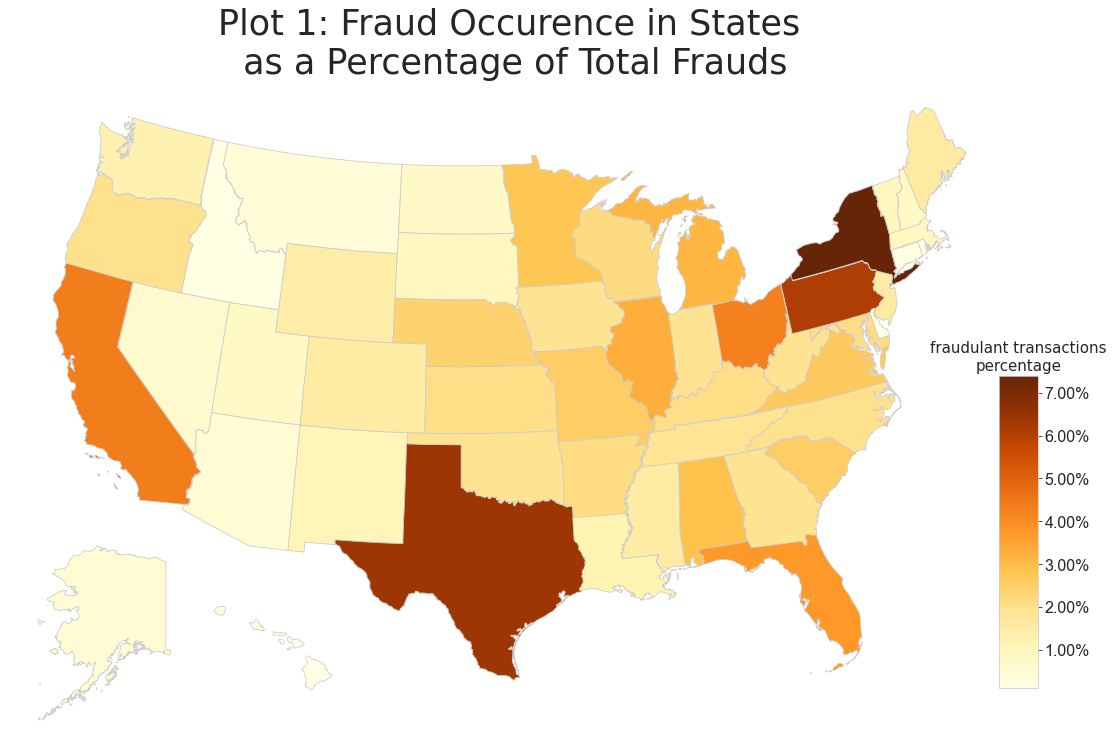

In [56]:
variable = 'mean_fraud'
# make a column for value_determined_color in gdf
# set the range for the clour scheme
vmin, vmax = us_states2[variable].min(), us_states2[variable].max()

colormap = "YlOrBr"

gdf = makeColorColumn(us_states2,variable,vmin,vmax)
visframe = gdf.to_crs({'init':'epsg:2163'})


fig, ax = plt.subplots(1, figsize=(18, 14))
ax.axis('off')
hfont = {'fontname':'Helvetica'}

# add a title and annotation
ax.set_title('Plot 1: Fraud Occurence in States\n as a Percentage of Total Frauds', **hfont, fontdict={'fontsize': '35', 'fontweight' : '1'})

# Create colorbar legend
fig = ax.get_figure()
# add colorbar axes to the figure
cbax = fig.add_axes([0.89, 0.21, 0.03, 0.31])  

cbax.set_title('fraudulant transactions\npercentage', **hfont, fontdict={'fontsize': '15', 'fontweight' : '0'})

# color scale
sm = plt.cm.ScalarMappable(cmap=colormap, \
                 norm=plt.Normalize(vmin=vmin, vmax=vmax))
# reformat tick labels on legend
sm._A = []
decimal_fmt = FuncFormatter(lambda x, p: format(x * 100, '.2f') + '%')
fig.colorbar(sm, cax=cbax, format=decimal_fmt)
cbax.tick_params(labelsize=16)


# create map
for row in visframe.itertuples():
    if row.STUSPS not in ['AK','HI']:
        vf = visframe[visframe.state==row.state]
        c = gdf[gdf.STUSPS==row.STUSPS][0:1].value_determined_color.item()
        vf.plot(color=c, linewidth=0.8, ax=ax, edgecolor='0.8')

# add Alaska
akax = fig.add_axes([0.1, 0.17, 0.2, 0.19])   
akax.axis('off')
# polygon to clip western islands
polygon = Polygon([(-170,50),(-170,72),(-140, 72),(-140,50)])
alaska_gdf = gdf[gdf.STUSPS=='AK']
alaska_gdf.clip(polygon).plot(color=gdf[gdf.STUSPS=='AK'].value_determined_color, linewidth=0.8,ax=akax, edgecolor='0.8')


# add Hawaii
hiax = fig.add_axes([.28, 0.20, 0.1, 0.1])   
hiax.axis('off')
# polygon to clip western islands
hipolygon = Polygon([(-160,0),(-160,90),(-120,90),(-120,0)])
hawaii_gdf = gdf[gdf.STUSPS=='HI']
hawaii_gdf.clip(hipolygon).plot(column=variable, color=hawaii_gdf['value_determined_color'], linewidth=0.8,ax=hiax, edgecolor='0.8')


Text(0.5, 1.0, 'Plot 2: Top 10 States with Highest Fraud Occurence\n')

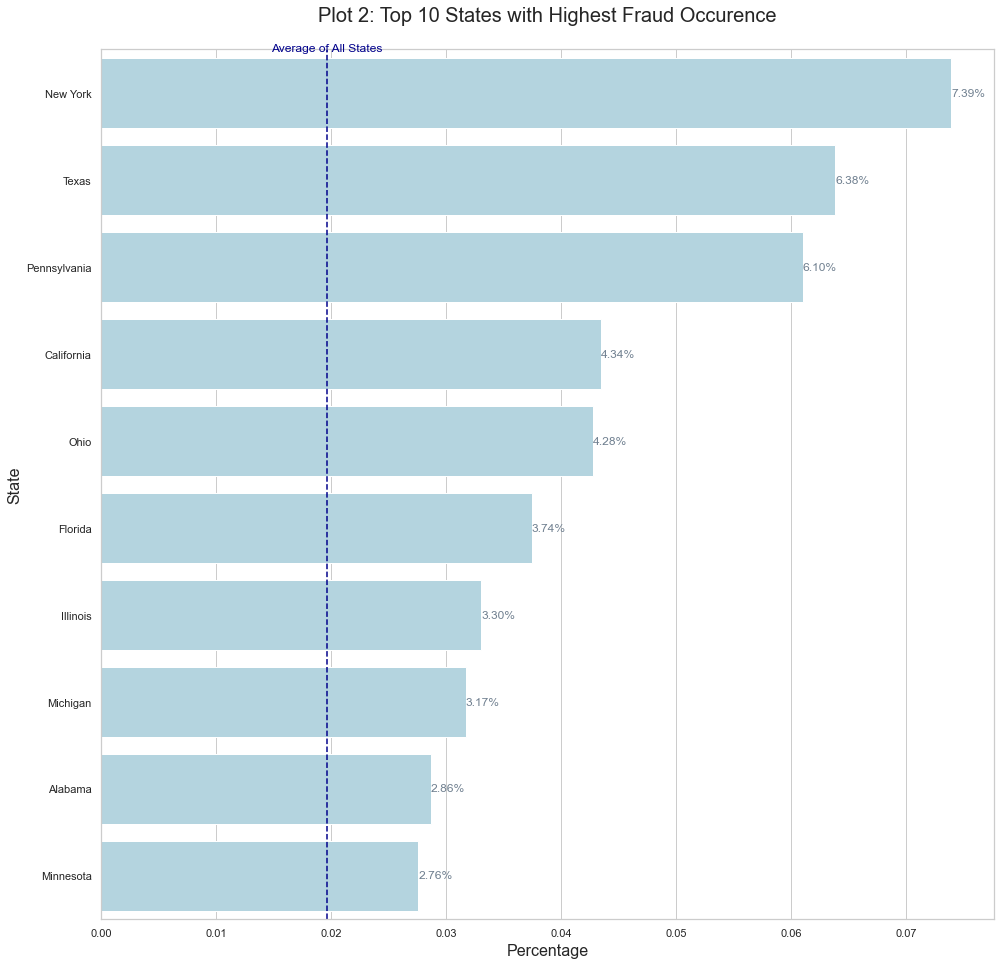

In [85]:
# Create a bar chart for clarity 

visFrame = gdf.sort_values(variable,ascending=False)[:100].head(10)
sns.set_style('whitegrid') #set theme
fig,ax=plt.subplots(figsize=(16,16))


chart1 = sns.barplot(x=variable,y='NAME',color='lightblue', data = visFrame)

national_average =  gdf[variable].mean()

ax.axvline(x=national_average, color='darkblue', linestyle='--', label='National Average')
ax.text(national_average, ax.get_ylim()[1] * 0.95, 'Average of All States', color='darkblue', fontsize=12, ha='center')

for i, value in enumerate(visFrame[variable]):
    ax.text(value, i, f'{value:.2%}', color='slategrey', ha='left', va='center', fontsize=12)


chart1.set_xlabel('Percentage',fontsize=16)
chart1.set_ylabel('State',fontsize=16)
chart1.set_title('Plot 2: Top 10 States with Highest Fraud Occurence\n',fontsize=20)


### 2. 2. Operating hours of the fraudulant transactions

The hours where the fraudulant transactions occur have a stark difference to how the non-fraud transactions take place. The fraud transactions operate mainly during the after hours and 22nd and 23rd hours are particularly important. 50% of the frauds are occuring during these two hours. This is an important pattern to look into when detecting fraud transactions. 

In [104]:
train['trans_date_trans_time'] = pd.to_datetime(train['trans_date_trans_time'])
train['weekday'] = train['trans_date_trans_time'].dt.day_name()
train['transaction_hour'] = train['trans_date_trans_time'].dt.hour

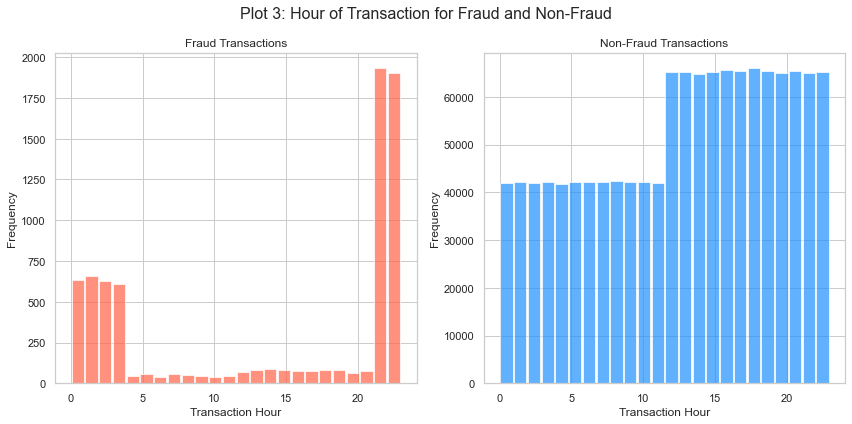

In [86]:


# Separate fraud and non-fraud transactions
fraud_data = train[train['is_fraud'] == 1]
non_fraud_data = train[train['is_fraud'] == 0]

# Plot histograms side by side
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(fraud_data['transaction_hour'], bins=24, color='#FF6347', alpha=0.7, rwidth=0.9)
plt.title('Fraud Transactions')
plt.xlabel('Transaction Hour')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(non_fraud_data['transaction_hour'], bins=24, color='#1E90FF', alpha=0.7, rwidth=0.9)
plt.title('Non-Fraud Transactions')
plt.xlabel('Transaction Hour')
plt.ylabel('Frequency')

plt.suptitle('Plot 3: Hour of Transaction for Fraud and Non-Fraud', fontsize=16)

plt.tight_layout()
plt.show()


### 2.3. Weekday of fraud transactions
The weekday of fraud occurence is particularly interesting. The occurence of fraud picks up mid week and the highest fraud occurence is on Thurseday. Wheras for non-fraud, the most business happen during the weekends.For legitimate transactions, Sunday is a busy day wheras it is the opposit for frauds.

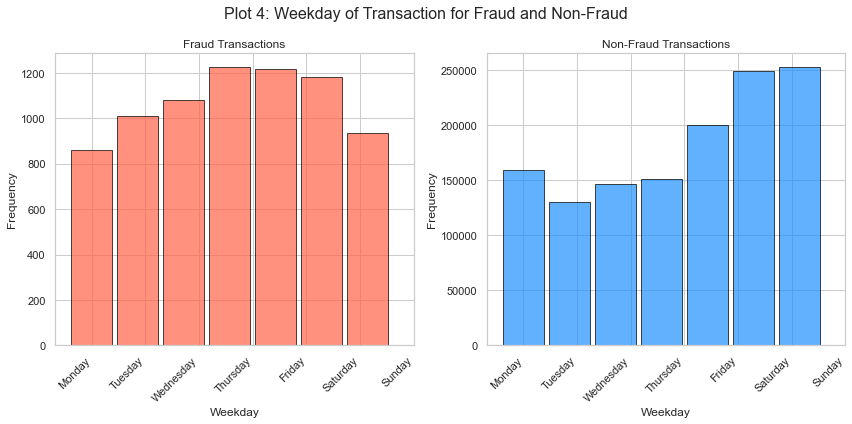

In [87]:
# Define the order of weekdays
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(fraud_data['weekday'], bins=7, color='#FF6347', alpha=0.7, rwidth=0.9, edgecolor='black', align='left')
plt.title('Fraud Transactions')
plt.xlabel('Weekday')
plt.ylabel('Frequency')
plt.xticks(range(len(weekday_order)), weekday_order, rotation=45, ha='right')  # Rotate x-axis labels for better readability

plt.subplot(1, 2, 2)
plt.hist(non_fraud_data['weekday'], bins=7, color='#1E90FF', alpha=0.7, rwidth=0.9, edgecolor='black', align='left')
plt.title('Non-Fraud Transactions')
plt.xlabel('Weekday')
plt.ylabel('Frequency')
plt.xticks(range(len(weekday_order)), weekday_order, rotation=45, ha='right')  # Rotate x-axis labels for better readability

plt.suptitle('Plot 4: Weekday of Transaction for Fraud and Non-Fraud', fontsize=16)

plt.tight_layout()
plt.show()


### 2.4. Average value of the fraud transactions

The average value of fraud transactions is quite high. Here, I have plotted the average value of fraud and non-fraud transactions using boxplots. The boxplots suggest that legitimate transactions are on average low in value compared to frauds. The spread of fraudulant transactions is limited which is indicated through the shorter whiskers in the boxplot. 



<ipython-input-89-057b6e86b64a>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], fontsize=12)


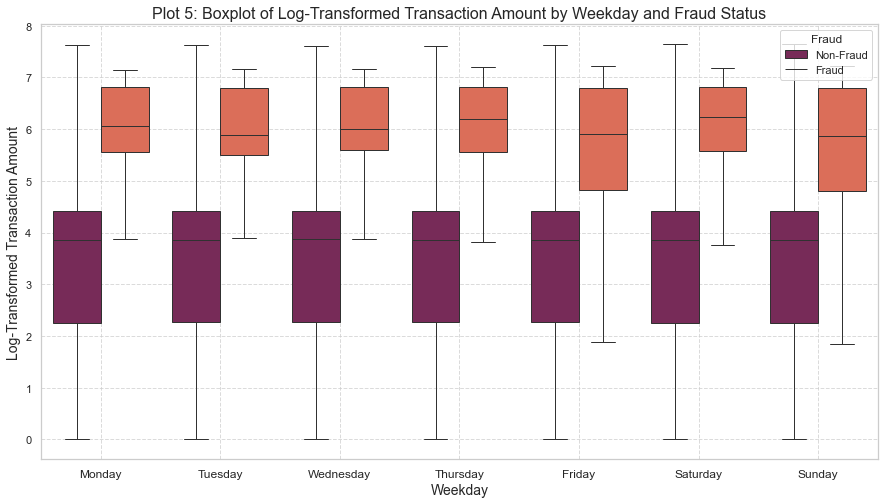

In [89]:

# Boxplot of transaction values
sns.set(style="whitegrid")
plt.figure(figsize=(15, 8))

# Use log scale for y-axis for better visibility
ax = sns.boxplot(x="weekday", y=np.log(train.amt), hue="is_fraud", data=train, palette="rocket", showfliers=False)

# Customize plot
ax.set_xlabel('Weekday', fontsize=14)
ax.set_ylabel('Log-Transformed Transaction Amount', fontsize=14)
ax.set_title('Plot 5: Boxplot of Log-Transformed Transaction Amount by Weekday and Fraud Status', fontsize=16)
ax.legend(title='Fraud', loc='upper right', labels=['Non-Fraud', 'Fraud'])

# Improve readability of x-axis labels
ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], fontsize=12)

# Add grid lines
ax.grid(True, linestyle='--', alpha=0.7)

plt.show()


## 4. Feature engineering

In order to predict the fraudulant transactions better we need to create new features out of the columns that are provided to us. The feature engineering part harnesses the already provided columns to create features that better predict our target variable. I create a set of business related features, synthetic features and other features based on the knowledge I gained on the dataset.

In [36]:

# freature creation 

def feature_eng_two(dataset):
    
    
    # 1. Trans amt Categories
    dataset['amt_category'] = pd.cut(dataset['amt'], bins=[0, 50, 100, 150, 200, float('inf')], labels=['Low', 'Medium-Low', 'Medium', 'Medium-High', 'High'])

    # 2. Distance Between Customer and Merchant
    dataset['distance_customer_merchant'] = ((dataset['lat'] - dataset['merch_lat'])**2 + (dataset['long'] - dataset['merch_long'])**2)**0.5

    # 3. Age of Customer
    dataset['dob'] = pd.to_datetime(dataset['dob'])
    dataset['age'] = ((datetime.now() - dataset['dob']).dt.days.astype('int'))/365

    # 4. merchant Cat frequency
    dataset['merchant_category_frequency'] = dataset.groupby('category')['category'].transform('count')

    # 5. transaction time since last transaction
    dataset['trans_time'] = pd.to_datetime(dataset['trans_date_trans_time'])
    dataset.sort_values(['cc_num', 'trans_time'], inplace=True)

    # 6. city pop density
    dataset['city_population_density'] = dataset['city_pop'] / dataset['city'].nunique()

    # 7. transaction Amt deviation from avg merchant
    dataset['amt_deviation_merchant_category'] = dataset['amt'] - dataset.groupby('category')['amt'].transform('mean')

    # 8. transaction Amt relative to avg of customer
    dataset['amt_relative_customer_average'] = dataset['amt'] / dataset.groupby('cc_num')['amt'].transform('mean')

    # 10. Merchant freqencey
    dataset['merchant_frequency_customer'] = dataset.groupby(['cc_num', 'category'])['category'].transform('count')

    # 11. amt relative to avg merchant
    dataset['amt_relative_merchant_average'] = dataset['amt'] / dataset.groupby('merchant')['amt'].transform('mean')

    # 12. avg trans amt per city
    dataset['avg_transaction_amount_city'] = dataset.groupby('city')['amt'].transform('mean')

    # 13. per person trans ratio
    dataset['amt_to_city_population_ratio'] = dataset['amt'] / dataset['city_pop']

    # 14. trans frequency by category
    dataset['transaction_frequency_category'] = dataset.groupby('category')['category'].transform('count')

    # 15. trans frequency by State
    dataset['transaction_frequency_state'] = dataset.groupby('state')['state'].transform('count')

    # 16. Trans amt deviation from mean
    dataset['amt_deviation_mean_category'] = dataset['amt'] - dataset.groupby('category')['amt'].transform('mean')

    # 17 Calculate the time difference within each credit card group
    dataset['time_since_last_transaction'] = dataset.groupby('cc_num')['trans_time'].diff().dt.total_seconds()
    dataset['time_since_last_transaction'].fillna(0, inplace=True)
    
    # 18 transaction type
    dataset['transaction_type'] = 'Other'
    dataset.loc[dataset['category'].str.contains('net', case=False), 'transaction_type'] = 'Net'
    dataset.loc[dataset['category'].str.contains('pos', case=False), 'transaction_type'] = 'POS'
    
    # 19. Time of the day
    dataset['time_of_day'] = np.where((dataset['transaction_hour'] >= 22) | (dataset['transaction_hour'] <= 23), 'Midnight',
                             np.where(dataset['transaction_hour'] <= 4, 'Dusk','Daytime'))
    
    us_holidays = holidays.UnitedStates()
    # 20. checking if a US hiliday
    dataset['is_holiday'] = dataset['trans_date_trans_time'].dt.date.apply(lambda x: 1 if x in us_holidays else 0)
    
    return dataset




In [37]:
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['weekday'] = df['trans_date_trans_time'].dt.day_name()
df['transaction_hour'] = df['trans_date_trans_time'].dt.hour

# df = feature_eng_one(df)

In [38]:

df = feature_eng_two(df)

### 4. 2. One hot Encoding

I need to convert the categorical columns into binary varibles. In this section I do the one-hot-encoding. 

In [39]:
drop_cols = ['index','Unnamed: 0','trans_date_trans_time','trans_time','cc_num','merchant','first','last','street','city','state','zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num','unix_time', 'merch_lat', 'merch_long']

df2 = df.drop(drop_cols, axis = 1)

cols_to_encode = ['category','transaction_type','time_of_day','gender','weekday','transaction_hour','amt_category']

df2 = pd.get_dummies(df2, columns = cols_to_encode)

### 4.3 Oversampling

As we have identified earlier, the target dataset is not very balanced where the "non_fraud" samples outnumber "fraud" observations heavily. This makes one class very difficult to classify. One method we can counter class imbalance is through the use of oversampling. We use SMOTE to correct the balance of our dataset. 
First I undersample the non-fraud ones and oversample the fraud occurences. 

In [78]:
x_train = df2[df2['dataset']=='train'][df2.columns.drop(['is_fraud','dataset'])]
y_train = df2[df2['dataset']=='train']['is_fraud']

oversample_ratio = {0: 75000, 1: 75000}

pipeline = Pipeline([
    ('undersample', RandomUnderSampler(sampling_strategy={0: 7500})),
    ('oversample', SMOTE(sampling_strategy=oversample_ratio)),
])


x_train_resampled, y_train_resampled = pipeline.fit_resample(x_train, y_train)


In [79]:
y_train_resampled.value_counts()

is_fraud
0    75000
1    75000
Name: count, dtype: int64

### 4.4 Correlation with the target variable

Correlation-based feature selection is one method to select features. We look at the pearson-correlation a variable has with the target variable. However, using correlation for feature selection did not yield robust results. 

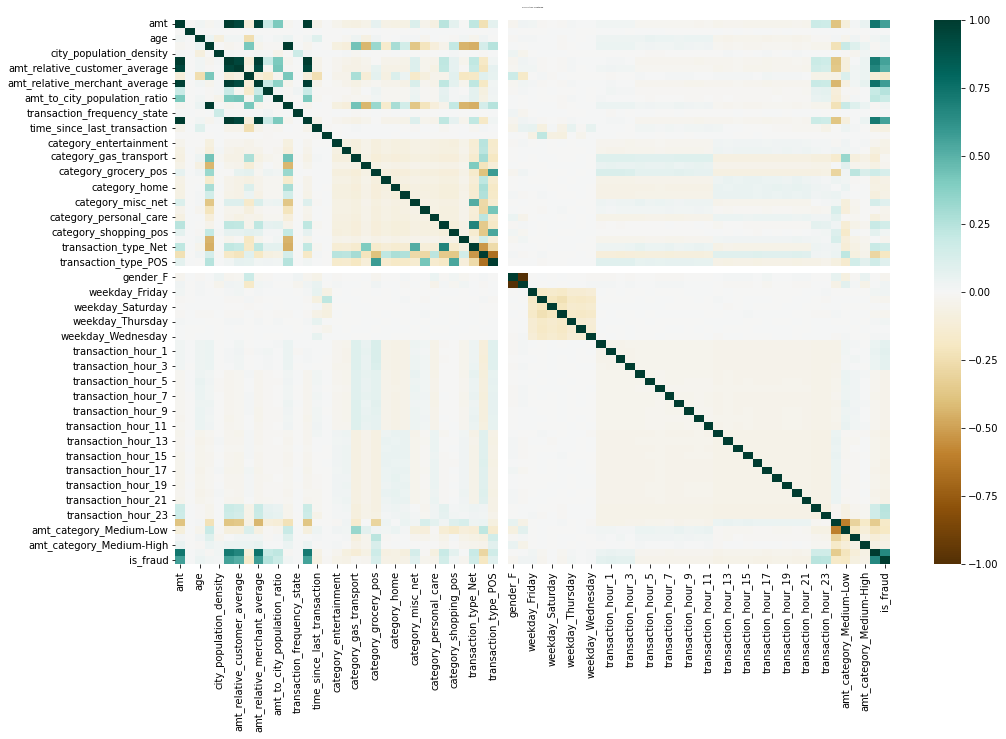

In [54]:
plt.figure(figsize=(16, 10))

heatmap = sns.heatmap(pd.concat([x_train_resampled, y_train_resampled], axis=1).corr(), vmin=-1, vmax=1, annot=False, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':2}, pad=12);

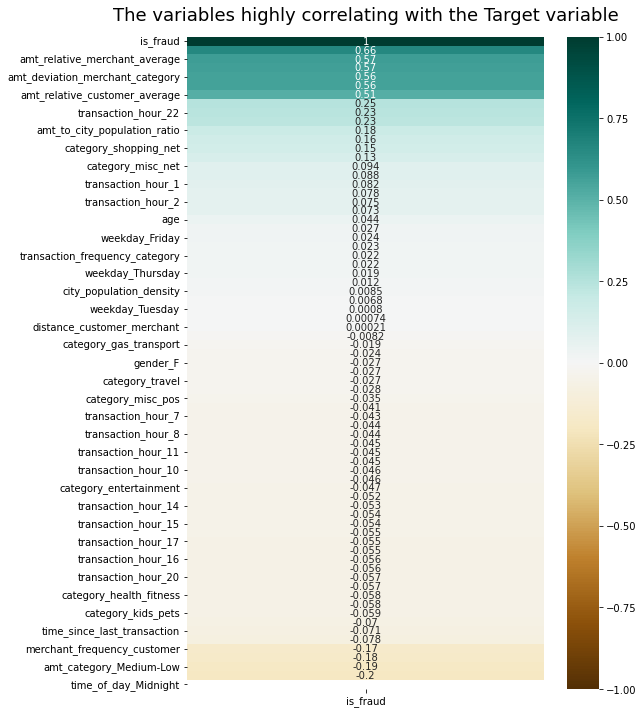

In [57]:
# Correlation with the target variable

plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(pd.concat([x_train_resampled, y_train_resampled], axis=1).corr()[['is_fraud']].sort_values(by='is_fraud', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('The variables highly correlating with the Target variable', fontdict={'fontsize':18}, pad=16);

## 5. Feature selection

Now that we have created a number of features, it is important to select the features that are only relevant to our prediction task. This will greatly reduce the computing requirements and create a very explainable accurate model. After experimenting with correlation-based feature selection, I settle with backward feature elimination which provided better results. In order to do this process we will use logistic regression as our base model. We will return the features of the model that provides us the best cross-validation score.

In [70]:


logr = LogisticRegression(solver = 'lbfgs', n_jobs = -1, max_iter = 100)
# logr = RandomForestClassifier()

logr.fit(x_train_resampled,y_train_resampled)


slect = SequentialFeatureSelector(logr,
                                  k_features = 'best',
                                  forward = False,
                                  n_jobs = -1,
                                  scoring = "f1",
                                  floating=False,
                                 cv = 3
                                 )
slect.fit(x_train_resampled,y_train_resampled)


SequentialFeatureSelector(cv=3, estimator=LogisticRegression(n_jobs=-1),
                          forward=False, k_features=(1, 72), n_jobs=-1,
                          scoring='f1')

In [71]:
len(slect.k_feature_names_)

46

Now that we have identified the best set of features, we will select our train, test datasets.

In [80]:
x_train = x_train_resampled[[*slect.k_feature_names_]]
# x_train = x[[*slect.k_feature_names_]]


y_train = y_train_resampled
# y_train = y

x_test = df2[df2['dataset']=='test'][[*slect.k_feature_names_]]
y_test = df2[df2['dataset']=='test']['is_fraud']

# 6. Modelling

In the modelling section we will test out 4 models. This problem is a binary classification machine learning problem. I have chosen a set of classic and more advanced algorithms of machine learning used for binary classification. We will start with logistic regression, which serves as a baseline model. Then look at random forest, an ensemble model and more advanced and efficient models such as GBM and LightGBM. 

1. Logistic regression
2. Random forest model.
3. LightGBM model.
4. Gradient boosting model.

For all the models we will tune parameters using cross validation accuracies. First we will set up our cross-validation platform. We perform 10 fold cross validation here in order to tune the parameters.

In [81]:
_random_seed = 1234

kfolds = KFold(n_splits=10, shuffle=True, random_state=_random_seed)

In [82]:
def tune(objective):
    study = optuna.create_study(direction="maximize",
                                sampler=optuna.samplers.TPESampler(seed=_random_seed)
                               )
    study.optimize(objective, n_trials=10)

    params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score} \nOptimized parameters: {params}")
    
    return params

## 6.1 Logistic regression

First, we will try out logistic regression. Logistic regression is a popular algorithm used to predict binary classifications. It is a classic machine learning technique which is widely popular and easy to implement and uses ordinary least squres technique. We have not scaled the data and the performance of this algorithm will suffer. This model will also help benchmark the other 3 more advanced ensemble models.

In [83]:
def log_objective(trial):

    _max_iter = trial.suggest_int("max_iter", 50, 1000)
    
    logr = LogisticRegression(class_weight = {0: 1, 1: 1},
                              solver = "lbfgs",
                              n_jobs = -1,
                              max_iter = _max_iter,
                              random_state=_random_seed)


    score = cross_val_score(
        logr,x_train,y_train, cv=kfolds, scoring="f1"
    ).mean()
    return score

log_params = tune(log_objective)

[I 2024-01-12 01:01:09,034] A new study created in memory with name: no-name-44b99151-7363-4f13-87f0-8f4ff8c2a2cc
[I 2024-01-12 01:01:24,780] Trial 0 finished with value: 0.682874171206673 and parameters: {'max_iter': 232}. Best is trial 0 with value: 0.682874171206673.
[I 2024-01-12 01:01:40,652] Trial 1 finished with value: 0.682874171206673 and parameters: {'max_iter': 641}. Best is trial 0 with value: 0.682874171206673.
[I 2024-01-12 01:01:56,047] Trial 2 finished with value: 0.682874171206673 and parameters: {'max_iter': 466}. Best is trial 0 with value: 0.682874171206673.
[I 2024-01-12 01:02:11,540] Trial 3 finished with value: 0.682874171206673 and parameters: {'max_iter': 796}. Best is trial 0 with value: 0.682874171206673.
[I 2024-01-12 01:02:27,178] Trial 4 finished with value: 0.682874171206673 and parameters: {'max_iter': 791}. Best is trial 0 with value: 0.682874171206673.
[I 2024-01-12 01:02:43,366] Trial 5 finished with value: 0.682874171206673 and parameters: {'max_iter

Best score: 0.682874171206673 
Optimized parameters: {'max_iter': 232}


In [84]:
logr = LogisticRegression(random_state=_random_seed, **log_params)
# logr = LogisticRegression()

logr.fit(x_train,y_train)

LogisticRegression(max_iter=232, random_state=1234)

In [85]:
y_pred_logr = logr.predict(x_test)

conmat_logr = confusion_matrix(y_test, y_pred_logr)

conmat_logr

array([[517389,  36185],
       [   498,   1647]], dtype=int64)

## 6.2 Random Forest Model

We will run a random forest model secondly. Random forest model is another tree based model and an ensemble model. In summary, it builds decision trees on bootsrapped samples and combine them in order to increase the predicting power. This model can be used for regression and classification problems.

In [86]:
def randomf_objective(trial):
    _min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    _max_depth = trial.suggest_int("max_depth", 1, 20)# ok
    _n_estimators = trial.suggest_int("n_estimators", 50, 100)# ok
    _min_samples_split = trial.suggest_int("min_samples_split", 1, 10)
    
    class_weights = {0: 1, 1: 1}


    
    rf = RandomForestClassifier(                          
                             min_samples_leaf=_min_samples_leaf,
                             max_depth=_max_depth,
                             n_estimators=_n_estimators,
                             min_samples_split=_min_samples_split,
                             random_state=_random_seed,
        
        class_weight=class_weights
    )
    

    score = cross_val_score(
        rf, x_train ,y_train, cv=kfolds, scoring="f1"
    ).mean()
    
    return score


rf_params = tune(randomf_objective)

[I 2024-01-12 01:04:17,383] A new study created in memory with name: no-name-b9ed6f01-1b21-47d5-b04d-8efa38c4b597
[I 2024-01-12 01:06:28,586] Trial 0 finished with value: 0.9633009799895905 and parameters: {'min_samples_leaf': 2, 'max_depth': 13, 'n_estimators': 72, 'min_samples_split': 8}. Best is trial 0 with value: 0.9633009799895905.
[I 2024-01-12 01:07:27,086] Trial 1 finished with value: 0.8877048555785837 and parameters: {'min_samples_leaf': 8, 'max_depth': 6, 'n_estimators': 64, 'min_samples_split': 9}. Best is trial 0 with value: 0.9633009799895905.
[I 2024-01-12 01:09:22,795] Trial 2 finished with value: 0.9733079618581627 and parameters: {'min_samples_leaf': 10, 'max_depth': 18, 'n_estimators': 68, 'min_samples_split': 6}. Best is trial 2 with value: 0.9733079618581627.
[I 2024-01-12 01:11:14,534] Trial 3 finished with value: 0.9682756782289147 and parameters: {'min_samples_leaf': 7, 'max_depth': 15, 'n_estimators': 68, 'min_samples_split': 6}. Best is trial 2 with value: 0.

Best score: 0.9802776727806087 
Optimized parameters: {'min_samples_leaf': 3, 'max_depth': 19, 'n_estimators': 72, 'min_samples_split': 10}


In [88]:
rf = RandomForestClassifier(random_state=_random_seed, **rf_params)
rf.fit(x_train,y_train)

RandomForestClassifier(max_depth=19, min_samples_leaf=3, min_samples_split=10,
                       n_estimators=72, random_state=1234)

In [89]:
y_pred_rf = rf.predict(x_test)

cm = confusion_matrix(y_test, y_pred_rf)
cm

array([[547791,   5783],
       [   240,   1905]], dtype=int64)

## 6.3 LightGBM

LightGBM was introduced recently and it builds on the gradient boosting principal. It builds the trees leaf-wise as opposed to level-wise in Xgboost. This algorithm is popular as it is fast but at the same time can handle a large amount of data.

In [90]:
def lgb_objective(trial):
    _num_leaves = trial.suggest_int("num_leaves", 50, 100)
    _max_depth = trial.suggest_int("max_depth", 1, 20)
    _learning_rate = trial.suggest_float("learning_rate", 0.01, 1)
    _n_estimators = trial.suggest_int("n_estimators", 50, 2000)
    _min_child_weight = trial.suggest_float("min_child_weight", 0.1, 10)
    _reg_alpha = trial.suggest_float('reg_alpha', 0.01, 10)
    _reg_lambda = trial.suggest_float('reg_lambda', 0.01, 10)
    _subsample = trial.suggest_float('subsample', 0.01, 1)
    
    lgbr = lgb.LGBMClassifier(objective='binary',
                             num_leaves=_num_leaves,
                             max_depth=_max_depth,
                             learning_rate=_learning_rate,
                             n_estimators=_n_estimators,
                             min_child_weight=_min_child_weight,
                             subsample=_subsample,
                             reg_alpha=_reg_alpha,
                             reg_lambda=_reg_lambda,
                             random_state=_random_seed,
    )
    

    score = cross_val_score(
        lgbr, x_train,y_train, cv=kfolds, scoring="f1"
    ).mean()
    return score

# Best score: 0.9673406338967385 
lgb_params = tune(lgb_objective)

[I 2024-01-12 01:20:51,227] A new study created in memory with name: no-name-918da802-9aba-40bf-8dae-e80fdcb3b5ea
[I 2024-01-12 01:21:35,890] Trial 0 finished with value: 0.9897924913396239 and parameters: {'num_leaves': 59, 'max_depth': 13, 'learning_rate': 0.44335046161704333, 'n_estimators': 1582, 'min_child_weight': 7.821760500376155, 'reg_alpha': 2.7332001267735895, 'reg_lambda': 2.771877908879536, 'subsample': 0.803853455759669}. Best is trial 0 with value: 0.9897924913396239.
[I 2024-01-12 01:22:09,438] Trial 1 finished with value: 0.9888322686756424 and parameters: {'num_leaves': 98, 'max_depth': 18, 'learning_rate': 0.364239097258288, 'n_estimators': 1027, 'min_child_weight': 6.866283058204149, 'reg_alpha': 7.1298932495591725, 'reg_lambda': 3.708805040356045, 'subsample': 0.5655842242049687}. Best is trial 0 with value: 0.9897924913396239.
[I 2024-01-12 01:22:52,779] Trial 2 finished with value: 0.9667177179708538 and parameters: {'num_leaves': 75, 'max_depth': 1, 'learning_ra

Best score: 0.9903999119478593 
Optimized parameters: {'num_leaves': 66, 'max_depth': 11, 'learning_rate': 0.12077537439865978, 'n_estimators': 1234, 'min_child_weight': 5.70285196620026, 'reg_alpha': 0.07757297928012787, 'reg_lambda': 6.178242670954927, 'subsample': 0.9130016575688228}


In [91]:
lgbr = lgb.LGBMClassifier(objective='binary', random_state=_random_seed, **lgb_params)
lgbr.fit(x_train,y_train)

LGBMClassifier(learning_rate=0.12077537439865978, max_depth=11,
               min_child_weight=5.70285196620026, n_estimators=1234,
               num_leaves=66, objective='binary', random_state=1234,
               reg_alpha=0.07757297928012787, reg_lambda=6.178242670954927,
               subsample=0.9130016575688228)

In [92]:
y_pred_lgb = lgbr.predict(x_test)
conmat_lgb = confusion_matrix(y_test, y_pred_lgb)
conmat_lgb

array([[547960,   5614],
       [   181,   1964]], dtype=int64)

## 6.4.  Gradient boosting model

It is a tree based model. It develops decision trees sequentially and eash subsequent model attempts to put more focus on instances the model struggles to predict accurately. This is a powerful ensemble algorithm can be used both for classification and regression problems.

In [95]:
def gbr_objective(trial):
    _n_estimators = trial.suggest_int("n_estimators", 50, 100)#2000
    _learning_rate = trial.suggest_float("learning_rate", 0.01, 1)
    _max_depth = trial.suggest_int("max_depth", 1, 10)
    _min_samp_split = trial.suggest_int("min_samples_split", 2, 20)
    _min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 20)

    gbr = GradientBoostingClassifier(
        n_estimators=_n_estimators,
        learning_rate=_learning_rate,
        max_depth=_max_depth, 
        min_samples_leaf=_min_samples_leaf,
        min_samples_split=_min_samp_split,
        
        random_state=_random_seed,
    )

    score = cross_val_score(
        gbr, x_train,y_train, cv=3, scoring="f1"
    ).mean()
    return score

# best score =  0.916216759311648
gbr_params = tune(gbr_objective)

[I 2024-01-12 01:45:06,732] A new study created in memory with name: no-name-92de09cf-58be-4004-bc45-27316801e4d1
[I 2024-01-12 01:46:31,014] Trial 0 finished with value: 0.9855425863567518 and parameters: {'n_estimators': 59, 'learning_rate': 0.6258876833294336, 'max_depth': 5, 'min_samples_split': 16, 'min_samples_leaf': 16}. Best is trial 0 with value: 0.9855425863567518.
[I 2024-01-12 01:49:23,751] Trial 1 finished with value: 0.9883898296058247 and parameters: {'n_estimators': 63, 'learning_rate': 0.2836996125916657, 'max_depth': 9, 'min_samples_split': 20, 'min_samples_leaf': 18}. Best is trial 1 with value: 0.9883898296058247.
[I 2024-01-12 01:51:47,570] Trial 2 finished with value: 0.9869468431452835 and parameters: {'n_estimators': 68, 'learning_rate': 0.5059851742682241, 'max_depth': 7, 'min_samples_split': 15, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.9883898296058247.
[I 2024-01-12 01:52:11,346] Trial 3 finished with value: 0.9427164551693457 and parameters: {'n

Best score: 0.9889844444840156 
Optimized parameters: {'n_estimators': 85, 'learning_rate': 0.2266041846173477, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 19}


In [96]:
gbr = GradientBoostingClassifier(random_state=_random_seed, **gbr_params)
gbr.fit(x_train,y_train)

GradientBoostingClassifier(learning_rate=0.2266041846173477, max_depth=10,
                           min_samples_leaf=19, min_samples_split=10,
                           n_estimators=85, random_state=1234)

In [97]:
y_pred_gb = gbr.predict(x_test)

conmat_gbr = confusion_matrix(y_test, y_pred_gb)

conmat_gbr

array([[548493,   5081],
       [   180,   1965]], dtype=int64)

# 7. Results


## 7.1 Model results metrics 

While there are many ways to compare the models, the accuracy score alone is not a good measure as this is an imbalanced dataset in itself. I believe the F1 score, the precision and the recall are good measures in this imbalanced dataset. Please note that we have classified the "fraud" observations as 1 and "non_fraud" ones as 0.

### The ROC curve

The ROC curve here shows an interesting pattern. It shows the trade-off between true positive rate and the false positive rate. Or in other words, how much false positives we can tolerate in order to correctly identify the true positives. The tree-based models seem to perform very equally here. 

In [98]:
lgb_prob = lgbr.predict_proba(x_test)[::,1]
rf_prob = rf.predict_proba(x_test)[::,1]
gbr_prob = gbr.predict_proba(x_test)[::,1]
logr_prob = logr.predict_proba(x_test)[::,1]

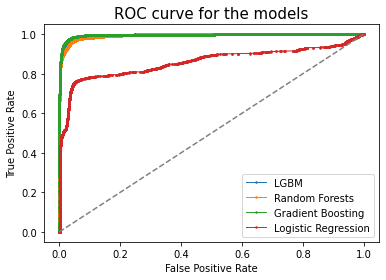

In [99]:
lr_fpr, lr_tpr, _ = roc_curve(y_test, lgb_prob)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_prob)
gbr_fpr, gbr_tpr, _ = roc_curve(y_test, gbr_prob)
logr_fpr, logr_tpr, _ = roc_curve(y_test, logr_prob)


pyplot.plot(lr_fpr, lr_tpr, marker='.', label='LGBM', linewidth=1, markersize=3)
pyplot.plot(rf_fpr, rf_tpr, marker='.', label='Random Forests', linewidth=1, markersize=3)
pyplot.plot(gbr_fpr, gbr_tpr, marker='.', label='Gradient Boosting', linewidth=1, markersize=3)
pyplot.plot(logr_fpr, logr_tpr, marker='.', label='Logistic Regression', linewidth=1, markersize=3)
pyplot.plot([0, 1], [0, 1], color = 'grey', linewidth = 1.5, linestyle='dashed')
pyplot.title("ROC curve for the models", size = 15)

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

### Model metrics

I have extracted the precision, recall and the F1 score and the accuracy of the models. The metrics are generated at 50% classification probability cut off threshold. 

When comparing the model results, it is clear that tree-based ensemble models have a better F1, precision, recall and accuracy figures. However the gradient boosting model slightly edges ahead compared to its cousines. Therefore, while all the 3 ensemble models perform very well, the gradient boosting model is the preferred model here based on the accuracy on unseen data.

In [100]:

def get_metrics(y_test, y_pred):
    """
    Gets precision, recall, F1 score, and accuracy metrics for models
    """
    classification_rep = classification_report(y_test, y_pred, output_dict=True)
    f1 = str(round(classification_rep['weighted avg']['f1-score'] * 100, 2)) + "%"

    return classification_rep, f1


lgbm_metrics, lgbm_f1 = get_metrics(y_test, y_pred_lgb)
rf_metrics, rf_f1 = get_metrics(y_test, y_pred_rf)
gbm_metrics, gbm_f1 = get_metrics(y_test, y_pred_gb)
logr_metrics, logr_f1 = get_metrics(y_test, y_pred_logr)


models = ['1. LGBM', '2. RF', '3. GBM', '4. Logistic']

precisions = [lgbm_metrics['weighted avg']['precision'], rf_metrics['weighted avg']['precision'],
              gbm_metrics['weighted avg']['precision'], logr_metrics['weighted avg']['precision']]

recalls = [lgbm_metrics['weighted avg']['recall'], rf_metrics['weighted avg']['recall'],
           gbm_metrics['weighted avg']['recall'], logr_metrics['weighted avg']['recall']]

f1_scores = [lgbm_f1, rf_f1, gbm_f1, logr_f1]

accuracies = [lgbm_metrics['accuracy'], rf_metrics['accuracy'], gbm_metrics['accuracy'], logr_metrics['accuracy']]


data = list(zip(models, precisions, recalls, f1_scores, accuracies))

# Print the metrics table
print(tabulate(data, headers=['Model', 'Precision', 'Recall', 'F1 Score', 'Accuracy']))


Model          Precision    Recall  F1 Score      Accuracy
-----------  -----------  --------  ----------  ----------
1. LGBM         0.996812  0.989572  99.25%        0.989572
2. RF           0.99666   0.989162  99.22%        0.989162
3. GBM          0.99689   0.990533  99.3%         0.990533
4. Logistic     0.99535   0.93399   96.24%        0.93399


#### Feature importance

The feature importance plot of the LightGBM is displayed below. We can see many synthetic features that I created have become very important in predicting fraud.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

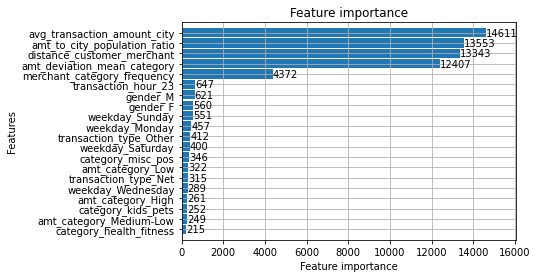

In [102]:
lgb.plot_importance(lgbr, max_num_features = 20, height=.9)

#### What would I do if I had more time?
If I had more time I would explore more into how the frauds occur in  the first place. That way I will have better knowledge about the process and can think of the problem in the fraudster's viewpoint. This will invariably provide me better opportunities to use different datasets and experiment in order to increase the accuracy of the model. I believe better data and logical application of theory will help us to better capture the frauds. Since we have ample data, we can look at more advanced models such as neural networks if the goal is to further reduce the fraud rate. 